<a href="https://colab.research.google.com/github/greo234/telediagnosiswithBERT/blob/main/TelemedicineBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset

In [ ]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The dataset is hosted on the my Github
filepath = 'https://raw.githubusercontent.com/greo234/telediagnosiswithBERT/main/text%20and%20symptoms_2.csv'

def load_dataset(dataset):
  df = pd.read_csv(dataset)
  df.drop(df.columns[0], axis=1, inplace=True)
  return df

df = load_dataset(filepath)

# Data Analysis

In [ ]:
df.head()

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [ ]:
df.isnull().sum()

Patient_Problem    0
Disease            0
dtype: int64

<ipython-input-4-ac65a7de1d62>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


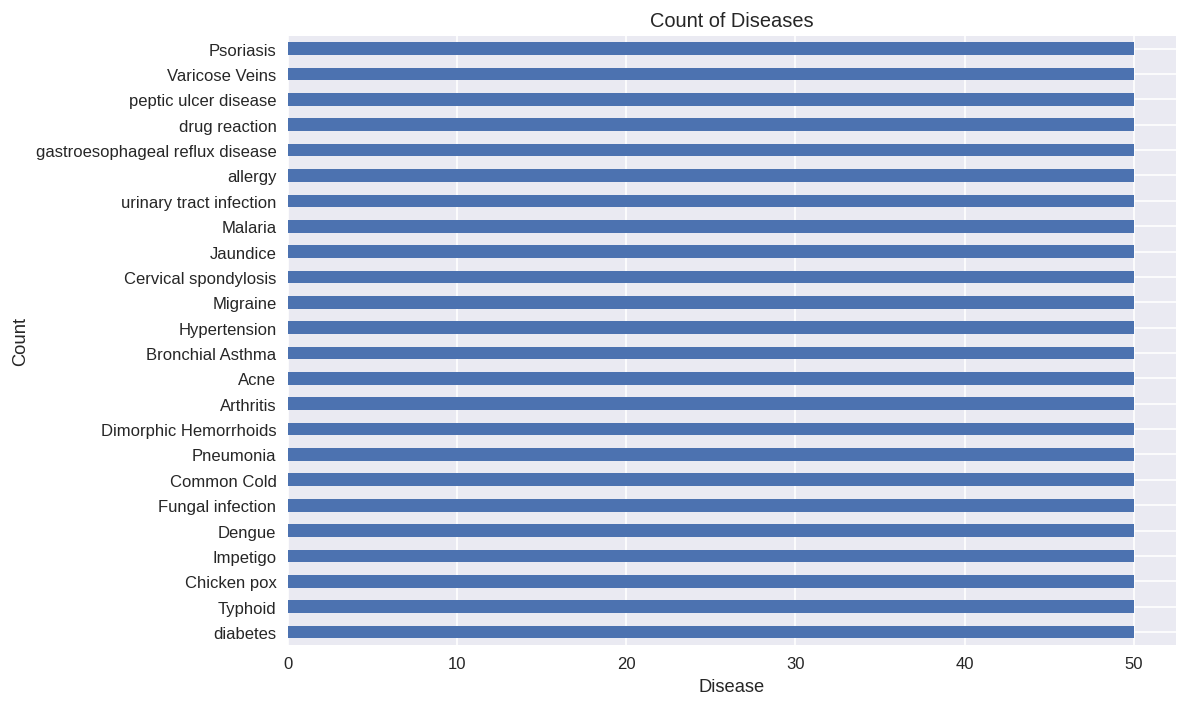

In [ ]:
# Plot the disease count
plt.style.use('seaborn')
plt.figure(figsize=(10, 6), dpi=120)
disease_count = df['Disease'].value_counts()
disease_count.plot(kind='barh')
plt.title('Count of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Total Number of diseases
print('Total number of Diseases: %d'%(len(df['Disease'].value_counts().index)))

Total number of Diseases: 24


# Data Pre-processing

In [ ]:
from sklearn.model_selection import train_test_split

def split_datasets(df):
  # Splitting the dataset into training and test sets for 'Patient_Problem' and 'Disease'
  X, y_disease = df['Patient_Problem'], df['Disease']
  X_train, problem_test, y_disease_train, disease_test = train_test_split(X, y_disease, stratify=y_disease, test_size=0.1, random_state=4612)

  # Further splitting the training set into training and validation sets
  problem_train, problem_val, disease_train, disease_val = train_test_split(X_train, y_disease_train, stratify=y_disease_train, test_size=0.20, random_state=4612)

  return problem_train, problem_val, disease_train, disease_val, problem_test, disease_test

problem_train, problem_val, disease_train, disease_val, problem_test, disease_test = split_datasets(df)

In [ ]:
print(f"samples in training set: {problem_train.shape[0]}\nsamples in validation set: {problem_val.shape[0]}\nsamples in test set: {problem_test.shape[0]}")

samples in training set: 864
samples in validation set: 216
samples in test set: 120


In [ ]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer with a pretrained model (e.g., 'bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

max_len = 0
input_ids = []

# For every problem...
for problem in problem_train:
    # Tokenize the problem and add special tokens--`[CLS]` and `[SEP]` tokens.
    tokens = tokenizer.encode(problem, add_special_tokens=True)
    input_ids.append(tokens)

    # Update the maximum sentence length.
    max_len = max(max_len, len(tokens))

# Calculate mean sentence length
mean_len = sum(len(tokens) for tokens in input_ids) / len(input_ids)

# Print the results
print('Max sentence length: %d \nMean sentence length: %d' % (max_len, mean_len))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max sentence length: 79 
Mean sentence length: 43


In [ ]:
def tokenize(problem):
  """
    Tokenize patient problems using the specified tokenizer.

    Returns:
    dict: Dictionary containing the tokenized inputs.
    """
  batch = tokenizer(list(problem),
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [ ]:
token_train = tokenize(problem_train)
token_val = tokenize(problem_val)
token_test = tokenize(problem_test)

In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(disease_train)))
label_val = torch.tensor((LE.fit_transform(disease_val)))
label_test = torch.tensor((LE.fit_transform(disease_test)))

In [ ]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(token_train['input_ids'], token_train['attention_mask'],label_train)
val_data = TensorDataset(token_val['input_ids'], token_val['attention_mask'],label_val)
test_data = TensorDataset(token_test['input_ids'], token_test['attention_mask'],label_test)

# Modeling, training and hyper-parameter tuning

In [ ]:
import datetime
import random
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define learning rates
learning_rates = [0.00001, 0.0001, 0.001]

# Define epochs and batch sizes
epochs = 10
batch_size = 32
val_batch = 64
# Initialize dictionaries to store metrics for each learning rate
train_metrics = {}
valid_metrics = {}

# Initialize variables to track the best performing model
best_valid_accuracy = 0
best_model_state_dict = None
best_metrics = {}

# Early stopping parameters
patience = 3
early_stopping_counter = 0

def train_and_get_best_model(epochs=epochs, batch_size=batch_size, val_batch=val_batch, train_metrics=train_metrics, valid_metrics=valid_metrics,
                             patience=patience, early_stopping_counter=early_stopping_counter):
  global best_valid_accuracy, best_model_state_dict, best_metrics
  for lr in learning_rates:
      print(f"Training with learning rate: {lr}")

      # Initialize the model
      model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)

      # Define data loaders for training and validation
      train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      valid_dataloader = DataLoader(val_data, batch_size=val_batch, shuffle=False)

      # Initialize optimizer and scheduler
      optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
      total_steps = len(train_dataloader) * epochs
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

      # Initialize lists to store metrics for this learning rate
      train_loss_list = []
      train_recall_list = []
      train_f1_list = []
      train_roc_auc_list = []
      train_accuracy_list = []  # New list to store training accuracy
      train_precision_list = []  # New list to store training precision
      valid_loss_list = []
      valid_recall_list = []
      valid_f1_list = []
      valid_roc_auc_list = []
      valid_accuracy_list = []
      valid_precision_list = []  # New list to store validation precision

      # Start the training process
      for epoch in range(epochs):
          model.train()
          total_train_loss = 0
          total_train_accuracy = 0
          total_train_precision = 0
          train_predictions = []
          train_labels = []

          for step, batch in enumerate(train_dataloader):
              # Forward pass
              inputs = {'input_ids': batch[0].to(device),
                        'attention_mask': batch[1].to(device),
                        'labels': batch[2].to(device)}
              outputs = model(**inputs)
              loss = outputs.loss
              logits = outputs.logits

              # Backward pass
              optimizer.zero_grad()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              scheduler.step()

              # Calculate training loss
              total_train_loss += loss.item()

              # Calculate training accuracy
              predictions = torch.argmax(logits, dim=1)
              accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
              total_train_accuracy += accuracy

              # Calculate training precision
              precision = precision_score(inputs['labels'].cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted', zero_division=0)
              total_train_precision += precision

              # Store predictions and labels for computing metrics
              train_predictions.extend(predictions.cpu().detach().numpy())
              train_labels.extend(inputs['labels'].cpu().detach().numpy())

          # Calculate average training loss
          avg_train_loss = total_train_loss / len(train_dataloader)

          # Calculate average training accuracy
          avg_train_accuracy = total_train_accuracy / len(train_dataloader)

          # Calculate average training precision
          avg_train_precision = total_train_precision / len(train_dataloader)

          # Calculate training metrics
          train_recall = recall_score(train_labels, train_predictions, average='weighted')
          train_f1 = f1_score(train_labels, train_predictions, average='weighted')
          train_roc_auc = roc_auc_score(label_binarize(train_labels, classes=np.arange(24)),
                                        label_binarize(train_predictions, classes=np.arange(24)),
                                        average='weighted')

          # Print and store metrics
          print(f"Epoch {epoch + 1}/{epochs}:")
          print(f"  Training Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Recall: {train_recall:.4f}, "
                f"F1: {train_f1:.4f}, AROC: {train_roc_auc:.4f}, Precision: {avg_train_precision:.4f}")

          train_loss_list.append(avg_train_loss)
          train_recall_list.append(train_recall)
          train_f1_list.append(train_f1)
          train_roc_auc_list.append(train_roc_auc)
          train_accuracy_list.append(avg_train_accuracy)
          train_precision_list.append(avg_train_precision)

          # Validation loop
          model.eval()
          total_valid_loss = 0
          total_valid_accuracy = 0
          total_valid_precision = 0
          valid_predictions = []
          valid_labels = []

          with torch.no_grad():
              for batch in valid_dataloader:
                  # Forward pass
                  inputs = {'input_ids': batch[0].to(device),
                            'attention_mask': batch[1].to(device),
                            'labels': batch[2].to(device)}
                  outputs = model(**inputs)
                  loss = outputs.loss
                  logits = outputs.logits

                  # Calculate validation loss
                  total_valid_loss += loss.item()

                  # Calculate validation accuracy
                  predictions = torch.argmax(logits, dim=1)
                  accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
                  total_valid_accuracy += accuracy

                  # Calculate validation precision
                  precision = precision_score(inputs['labels'].cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted', zero_division=0) #, zero_division="warn"
                  total_valid_precision += precision

                  # Store predictions and labels for computing metrics
                  valid_predictions.extend(predictions.cpu().detach().numpy())
                  valid_labels.extend(inputs['labels'].cpu().detach().numpy())

          # Calculate average validation loss
          avg_valid_loss = total_valid_loss / len(valid_dataloader)

          # Calculate average validation accuracy
          avg_valid_accuracy = total_valid_accuracy / len(valid_dataloader)

          # Calculate average validation precision
          avg_valid_precision = total_valid_precision / len(valid_dataloader)

          # Calculate validation metrics
          valid_recall = recall_score(valid_labels, valid_predictions, average='weighted')
          valid_f1 = f1_score(valid_labels, valid_predictions, average='weighted')
          valid_roc_auc = roc_auc_score(label_binarize(valid_labels, classes=np.arange(24)),
                                        label_binarize(valid_predictions, classes=np.arange(24)),
                                        average='weighted')

          # Print and store metrics
          print(f"  Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_accuracy:.4f}, Recall: {valid_recall:.4f}, "
                f"F1: {valid_f1:.4f}, AROC: {valid_roc_auc:.4f}, Precision: {avg_valid_precision:.4f}")

          valid_loss_list.append(avg_valid_loss)
          valid_recall_list.append(valid_recall)
          valid_f1_list.append(valid_f1)
          valid_roc_auc_list.append(valid_roc_auc)
          valid_accuracy_list.append(avg_valid_accuracy)
          valid_precision_list.append(avg_valid_precision)

          # Update best performing model based on validation accuracy
          if avg_valid_accuracy > best_valid_accuracy:
              best_valid_accuracy = avg_valid_accuracy
              best_model_state_dict = model.state_dict()
              best_metrics = {
                  'learning_rate': lr,  # Add the learning rate
                  'epoch': epoch + 1,
                  'train_loss': avg_train_loss,
                  'valid_loss': avg_valid_loss,
                  'train_accuracy': avg_train_accuracy,
                  'valid_accuracy': avg_valid_accuracy,
                  'train_recall': train_recall,
                  'valid_recall': valid_recall,
                  'train_f1': train_f1,
                  'valid_f1': valid_f1,
                  'train_roc_auc': train_roc_auc,
                  'valid_roc_auc': valid_roc_auc,
                  'train_precision': avg_train_precision,
                  'valid_precision': avg_valid_precision
              }

          # Early stopping
          if epoch > 0 and valid_loss_list[-1] > valid_loss_list[-2]:
              early_stopping_counter += 1
              if early_stopping_counter >= patience:
                  print("Early stopping triggered.")
                  break
          else:
              early_stopping_counter = 0

      # Store metrics for this learning rate
      train_metrics[lr] = {
          'loss': train_loss_list,
          'recall': train_recall_list,
          'f1': train_f1_list,
          'roc_auc': train_roc_auc_list,
          'accuracy': train_accuracy_list,
          'precision': train_precision_list
      }
      valid_metrics[lr] = {
          'loss': valid_loss_list,
          'recall': valid_recall_list,
          'f1': valid_f1_list,
          'roc_auc': valid_roc_auc_list,
          'accuracy': valid_accuracy_list,
          'precision': valid_precision_list
      }
  return model, train_metrics, valid_metrics
model, train_metrics, valid_metrics = train_and_get_best_model()
# After training loop, load the best model state
model.load_state_dict(best_model_state_dict)

# Print best performing model and its metrics
print("Best Performing Model Metrics:")
print(best_metrics)



Training with learning rate: 1e-05


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 3.1551, Accuracy: 0.0556, Recall: 0.0556, F1: 0.0183, AROC: 0.5072, Precision: 0.0157
  Validation Loss: 3.0219, Accuracy: 0.0768, Recall: 0.0833, F1: 0.0167, AROC: 0.5217, Precision: 0.0106
Epoch 2/10:
  Training Loss: 2.9258, Accuracy: 0.2072, Recall: 0.2072, F1: 0.1643, AROC: 0.5864, Precision: 0.1879
  Validation Loss: 2.7170, Accuracy: 0.3750, Recall: 0.3519, F1: 0.3050, AROC: 0.6618, Precision: 0.3608
Epoch 3/10:
  Training Loss: 2.6066, Accuracy: 0.4630, Recall: 0.4630, F1: 0.4197, AROC: 0.7198, Precision: 0.4607
  Validation Loss: 2.4120, Accuracy: 0.6055, Recall: 0.5787, F1: 0.5107, AROC: 0.7802, Precision: 0.5596
Epoch 4/10:
  Training Loss: 2.3454, Accuracy: 0.6100, Recall: 0.6100, F1: 0.5660, AROC: 0.7965, Precision: 0.5912
  Validation Loss: 2.1618, Accuracy: 0.7031, Recall: 0.6944, F1: 0.6466, AROC: 0.8406, Precision: 0.7005
Epoch 5/10:
  Training Loss: 2.1173, Accuracy: 0.7199, Recall: 0.7199, F1: 0.6870, AROC: 0.8539, Precision: 0.7282
  Val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 2.8534, Accuracy: 0.2315, Recall: 0.2315, F1: 0.2142, AROC: 0.5990, Precision: 0.1848
  Validation Loss: 2.0574, Accuracy: 0.5898, Recall: 0.5833, F1: 0.5223, AROC: 0.7826, Precision: 0.5636
Epoch 2/10:
  Training Loss: 1.4822, Accuracy: 0.7512, Recall: 0.7512, F1: 0.7269, AROC: 0.8702, Precision: 0.7367
  Validation Loss: 0.8338, Accuracy: 0.9010, Recall: 0.8981, F1: 0.8810, AROC: 0.9469, Precision: 0.8731
Epoch 3/10:
  Training Loss: 0.5481, Accuracy: 0.9387, Recall: 0.9387, F1: 0.9365, AROC: 0.9680, Precision: 0.9530
  Validation Loss: 0.3199, Accuracy: 0.9622, Recall: 0.9630, F1: 0.9625, AROC: 0.9807, Precision: 0.9673
Epoch 4/10:
  Training Loss: 0.1742, Accuracy: 0.9907, Recall: 0.9907, F1: 0.9908, AROC: 0.9952, Precision: 0.9960
  Validation Loss: 0.1211, Accuracy: 0.9844, Recall: 0.9815, F1: 0.9807, AROC: 0.9903, Precision: 0.9882
Epoch 5/10:
  Training Loss: 0.0585, Accuracy: 0.9965, Recall: 0.9965, F1: 0.9965, AROC: 0.9982, Precision: 0.9986
  Val

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10:
  Training Loss: 3.3760, Accuracy: 0.0405, Recall: 0.0405, F1: 0.0337, AROC: 0.4994, Precision: 0.0170
  Validation Loss: 3.2767, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0018
Epoch 2/10:
  Training Loss: 3.3090, Accuracy: 0.0394, Recall: 0.0394, F1: 0.0345, AROC: 0.4988, Precision: 0.0257
  Validation Loss: 3.2544, Accuracy: 0.0482, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0030
Epoch 3/10:
  Training Loss: 3.2974, Accuracy: 0.0312, Recall: 0.0312, F1: 0.0226, AROC: 0.4946, Precision: 0.0147
  Validation Loss: 3.2622, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0018
Epoch 4/10:
  Training Loss: 3.2698, Accuracy: 0.0463, Recall: 0.0463, F1: 0.0350, AROC: 0.5024, Precision: 0.0119
  Validation Loss: 3.3037, Accuracy: 0.0417, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0023
Epoch 5/10:
  Training Loss: 3.3202, Accuracy: 0.0289, Recall: 0.0289, F1: 0.0176, AROC: 0.4934, Precision: 0.0081
  Val

# Model Train Evaluation

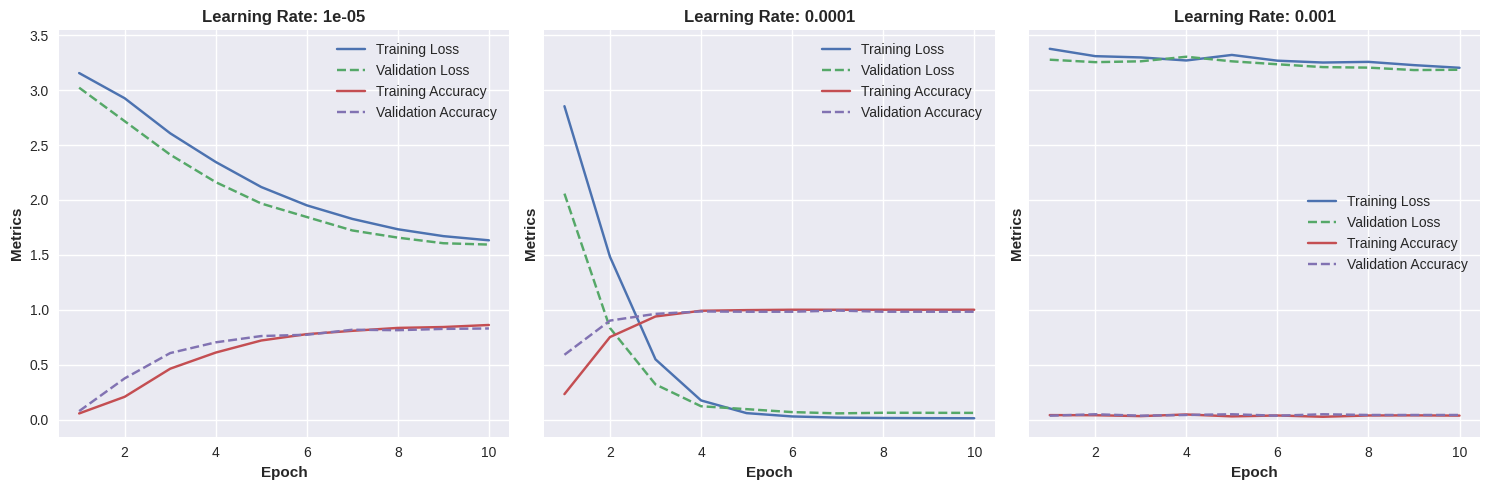

In [ ]:
# Plotting the metrics for each learning rate separately
fig, axs = plt.subplots(1, len(learning_rates), figsize=(5*len(learning_rates), 5), sharey=True)

# Loop through each learning rate
for i, lr in enumerate(learning_rates):
    ax = axs[i]
    ax.plot(range(1, len(train_metrics[lr]['loss']) + 1), train_metrics[lr]['loss'], label='Training Loss')
    ax.plot(range(1, len(valid_metrics[lr]['loss']) + 1), valid_metrics[lr]['loss'], label='Validation Loss', linestyle='--')
    ax.plot(range(1, len(train_metrics[lr]['accuracy']) + 1), train_metrics[lr]['accuracy'], label='Training Accuracy')
    ax.plot(range(1, len(valid_metrics[lr]['accuracy']) + 1), valid_metrics[lr]['accuracy'], label='Validation Accuracy', linestyle='--')
    ax.set_xlabel('Epoch', rotation=0, fontweight='bold')  # Rotate x-axis labels by 45 degrees and set to bold
    ax.set_ylabel('Metrics', fontweight='bold')            # Set y-axis label to bold
    ax.set_title(f'Learning Rate: {lr}', fontweight='bold')   # Set title to bold
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()




# Save the model

In [ ]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory path to save the model in Google Drive
model_dir_drive = '/content/drive/My Drive/BERT'

def save_model(model_dir_drive):
  # Create the directory if it doesn't exist
  os.makedirs(model_dir_drive, exist_ok=True)
  # Save the best model's state dictionary
  torch.save(best_model_state_dict, os.path.join(model_dir_drive, "best_model_state_dict.pth"))
  # Optionally, save the tokenizer
  #tokenizer.save_pretrained(model_dir_drive)

save_model(model_dir_drive)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model Test Evaluation

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the path to the saved model file
saved_model_path = "/content/drive/My Drive/BERT/best_model_state_dict.pth"

def load_model(saved_model_path):
  # Initialize the model architecture
  model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)
  # Load the saved model's state dictionary
  state_dict = torch.load(saved_model_path)
  # Load the state dictionary into the model
  model.load_state_dict(state_dict)
  # Move the model to the appropriate device (e.g., GPU)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  return model

model = load_model(saved_model_path)

# Initialize lists to store predictions and true labels
all_predictions = []
all_labels = []

def test_predict():
  global all_predictions, all_labels
  #Test Loader
  test_dataloader = DataLoader(test_data, batch_size=val_batch, shuffle=False)

  # Iterate over batches of test data
  for batch in test_dataloader:
      # Move inputs to the appropriate device (e.g., GPU)
      inputs = {'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device),
                'labels': batch[2].to(device)}

      # Forward pass
      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits

      # Process logits to get predictions
      predictions = torch.argmax(logits, dim=1)

      # Collect predictions and true labels
      all_predictions.extend(predictions.cpu().tolist())
      all_labels.extend(inputs['labels'].cpu().tolist())

test_predict()

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.975
Precision: 0.9791666666666666
Recall: 0.975
F1-score: 0.9747474747474747
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 

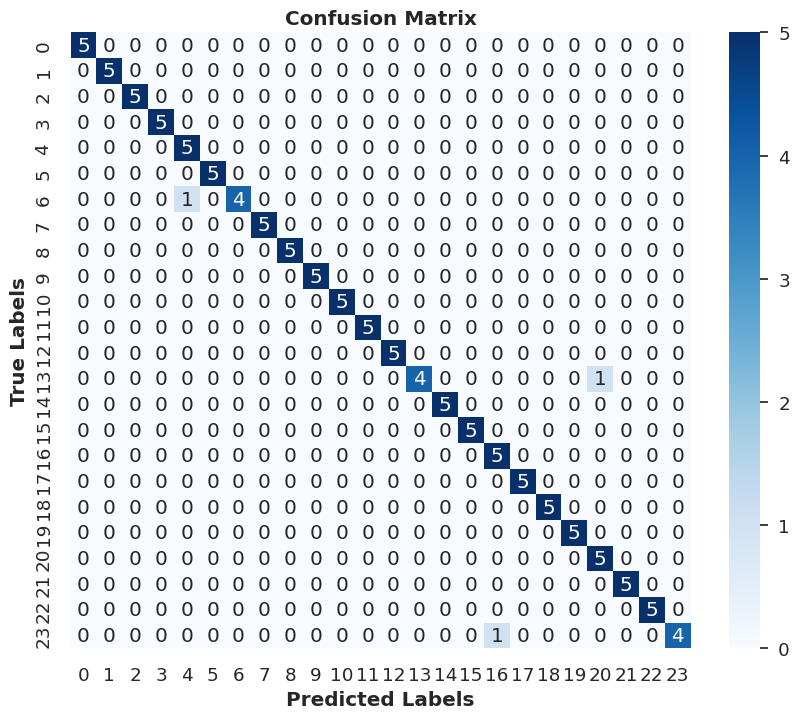

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('True Labels', fontweight='bold')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

